# Errors and Noise - getting most of NISQ computers

In [1]:
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.visualization import *
from qiskit.tools.jupyter import *
import pprint
from qiskit.tools.monitor import backend_overview, backend_monitor
from qiskit.compiler import transpile, assemble
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer
from qiskit.transpiler import PassManager
from qiskit.visualization import pass_manager_drawer
from qiskit.transpiler.passes import Unroller
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler
from qiskit_ibm_provider import IBMProvider

In [6]:
provider = IBMQ.load_account()

C:\Users\P39686820\AppData\Local\Temp\ipykernel_30044\2020123530.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


In [7]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_brisbane') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_kyoto') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_osaka') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [8]:
backend_overview()

ibm_osaka                    ibm_kyoto                    ibm_brisbane
---------                    ---------                    ------------
Num. Qubits:  127            Num. Qubits:  127            Num. Qubits:  127
Pending Jobs: 2              Pending Jobs: 31             Pending Jobs: 113
Least busy:   True           Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      290.7          Avg. T1:      217.3          Avg. T1:      217.4
Avg. T2:      185.3          Avg. T2:      127.3          Avg. T2:      141.7





In [10]:
backend = provider.get_backend('ibm_kyoto')

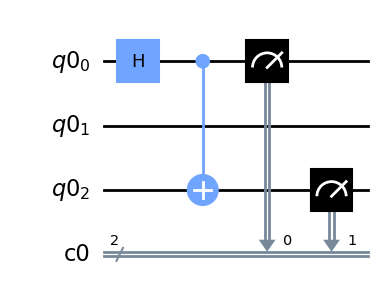

In [10]:
qr = QuantumRegister(3)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.cx(qr[0], qr[2])
circuit.measure(qr[0], cr[0])
circuit.measure(qr[2], cr[1])

circuit.draw(output='mpl')

In [16]:
#job = execute(circuit, backend=backend, shots=1024)
#job.status()

<JobStatus.QUEUED: 'job is queued'>

In [17]:
#job.job_id()

'cnmfdbnpzmsg008wvbv0'

In [28]:
#job.status()

<JobStatus.DONE: 'job has successfully run'>

In [29]:
#print(job.queue_position())

None


In [11]:
job=backend.retrieve_job('cnmfdbnpzmsg008wvbv0')

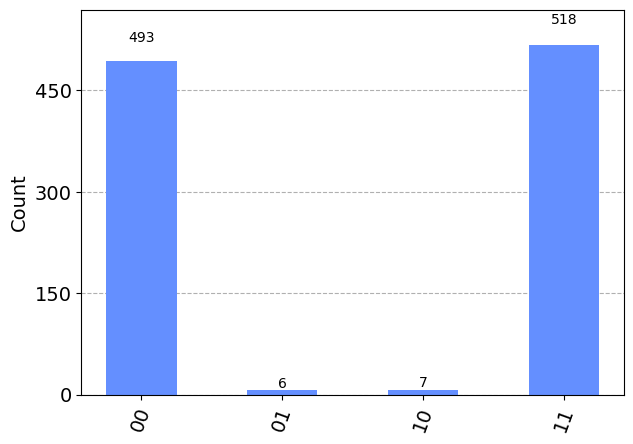

In [12]:
counts = job.result().get_counts()
plot_histogram(counts)

# Mitigating readout errors

In [43]:
#QiskitRuntimeService.save_account(channel="ibm_quantum", overwrite='true', token="<TOKEN_HERE>")

In [ ]:
service = QiskitRuntimeService(channel="ibm_quantum")
    
options = Options()
options.resilience_level = 1
options.optimization_level = 3
options.execution.shots = 1024

backend = service.backend("ibm_kyoto")
 
sampler = Sampler(backend, options=options) 

job = sampler.run(circuits=circuit)
print(f"Job ID is {job.job_id()}")

result = job.result()
print(f"Job result is {result}")

Job ID is cnrth0wgsbh0008syk00


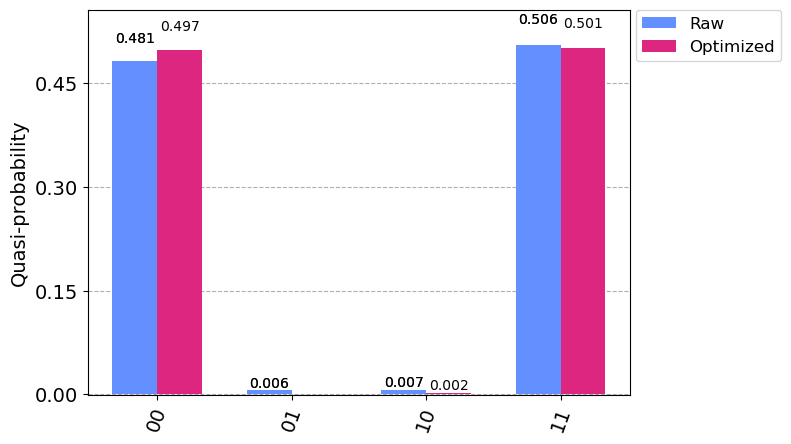

In [52]:
counts_optimized = result.quasi_dists[0].binary_probabilities()
plot_histogram([counts, counts_optimized], legend=["Raw", "Optimized"])

## Analyzing backend properties to understand it's limitatations and be able to tune the algorithms

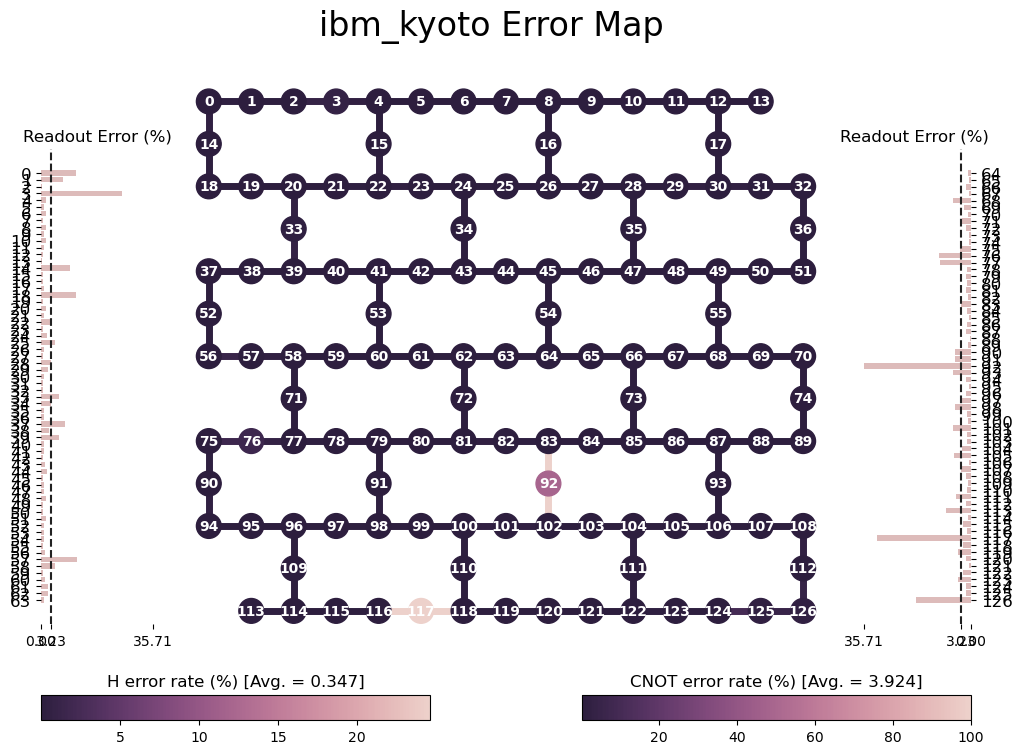

In [12]:
plot_error_map(backend)

In [11]:
backend_monitor(backend)

ibm_kyoto
Configuration
-------------
    n_qubits: 127
    operational: True
    status_msg: active
    pending_jobs: 31
    backend_version: 1.2.0
    basis_gates: ['id', 'rz', 'sx', 'x', 'ecr', 'reset']
    local: False
    simulator: False
    rep_times: [1000.0]
    pulse_num_channels: 9
    url: None
    u_channel_lo: [[{'q': 14, 'scale': (1+0j)}], [{'q': 0, 'scale': (1+0j)}], [{'q': 2, 'scale': (1+0j)}], [{'q': 2, 'scale': (1+0j)}], [{'q': 3, 'scale': (1+0j)}], [{'q': 5, 'scale': (1+0j)}], [{'q': 5, 'scale': (1+0j)}], [{'q': 6, 'scale': (1+0j)}], [{'q': 7, 'scale': (1+0j)}], [{'q': 9, 'scale': (1+0j)}], [{'q': 16, 'scale': (1+0j)}], [{'q': 10, 'scale': (1+0j)}], [{'q': 10, 'scale': (1+0j)}], [{'q': 12, 'scale': (1+0j)}], [{'q': 13, 'scale': (1+0j)}], [{'q': 4, 'scale': (1+0j)}], [{'q': 26, 'scale': (1+0j)}], [{'q': 12, 'scale': (1+0j)}], [{'q': 30, 'scale': (1+0j)}], [{'q': 14, 'scale': (1+0j)}], [{'q': 19, 'scale': (1+0j)}], [{'q': 20, 'scale': (1+0j)}], [{'q': 20, 'scale': (1+

# How we can analyze circuit size and complexity

* Very important to understand what is our final circuit after transpilation as it directly impacts the results.
* The more gates, the more errors get introduced

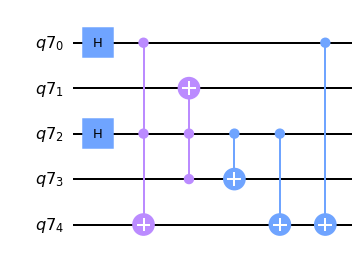

In [69]:
from qiskit import QuantumCircuit, QuantumRegister

q = QuantumRegister(5)
circuit2 = QuantumCircuit(q)
circuit2.h(q[0])
circuit2.h(q[2])
circuit2.ccx(q[0], q[2], q[4])
circuit2.ccx(q[3], q[2], q[1])
circuit2.cx(q[2], q[3])
circuit2.cx(q[2], q[4])
circuit2.cx(q[0], q[4])
circuit2.draw(output='mpl')

In [70]:
# total number of operations in the circuit. no unrolling is done.
circuit2.size()

7

In [72]:
# number of qubits in the circuit
circuit2.width()

5

In [73]:
circuit2.depth()

6

In [74]:
# a breakdown of operations by type
circuit2.count_ops()

OrderedDict([('cx', 3), ('h', 2), ('ccx', 2)])

# Transpilation

In [91]:
backend = provider.get_backend('ibmq_lima')
circuit2_transpiled = transpile(circuit2, backend)

In [92]:
circuit2_transpiled.size()

59

In [93]:
circuit2_transpiled.width()

5

In [94]:
circuit2_transpiled.depth()

38

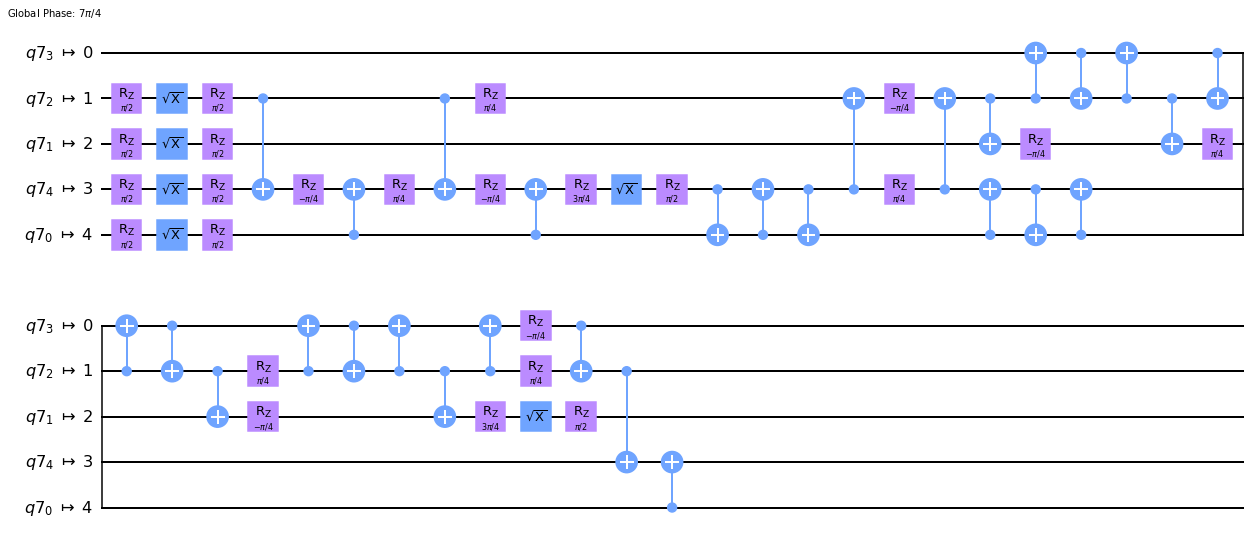

In [95]:
circuit2_transpiled.draw('mpl')

## Exercise

1) Create a circuit which will realize superposition of two states: 01010100 and 01010011.
1) Run the circuit on simulator and verify if indeed the two desired states are the only reults
1) Since we do not have time to wait for running the circuit onm real backend, run in on simulator with noise (which simulates real backend). Compare the results.

### Hint: simplest way to run quantum circuit:

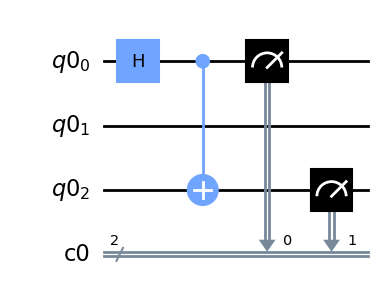

In [13]:
qr = QuantumRegister(3)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.cx(qr[0], qr[2])
circuit.measure(qr[0], cr[0])
circuit.measure(qr[2], cr[1])

circuit.draw(output='mpl')

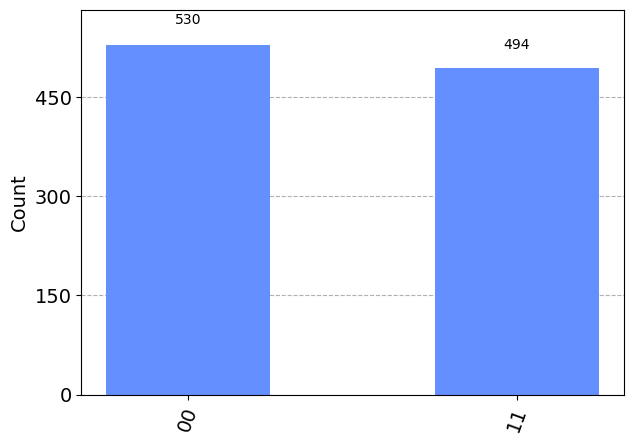

In [18]:
simulator = provider.get_backend('ibmq_qasm_simulator')
job = execute(circuit, backend=simulator, shots=1024)
counts = job.result().get_counts()
plot_histogram(counts)

### Running on 'noisy simulator'

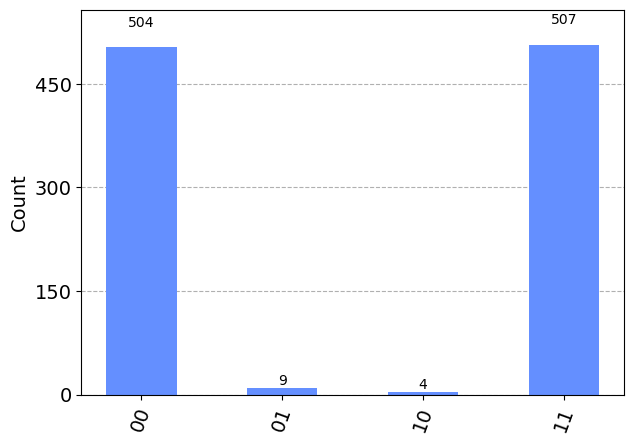

In [19]:
#from qiskit.test.mock import FakeKyoto
from qiskit.providers.fake_provider import FakeWashington
simulator_kuoto = FakeWashington()

job = execute(circuit, backend=simulator_kuoto, shots=1024)
counts = job.result().get_counts()
plot_histogram(counts)

## Homework 1

1) Find binary representation of your initials
1) Create a circuit which realizes superposition of these two states
1) Run the circuit on simulator and verify if the result indeed contains the desired two states. Draw a histogram.
1) Run the same circuit on real backend and compare histograms

## Homework 2

Watch the key note from IBM Quantum Summit 2023: https://www.youtube.com/watch?v=De2IlWji8Ck